<a href="https://colab.research.google.com/github/AndyVitoria/mpca_redes_neurais/blob/main/Atividade_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from abc import ABC, abstractstaticmethod,abstractmethod
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from scipy.special import expit
from sklearn.metrics import accuracy_score

In [2]:
dataset = load_wine(as_frame=True)
df = dataset.data
target = dataset.target
target

0      0
1      0
2      0
3      0
4      0
      ..
173    2
174    2
175    2
176    2
177    2
Name: target, Length: 178, dtype: int64

In [3]:
df.head(10)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0
8,14.83,1.64,2.17,14.0,97.0,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045.0
9,13.86,1.35,2.27,16.0,98.0,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045.0


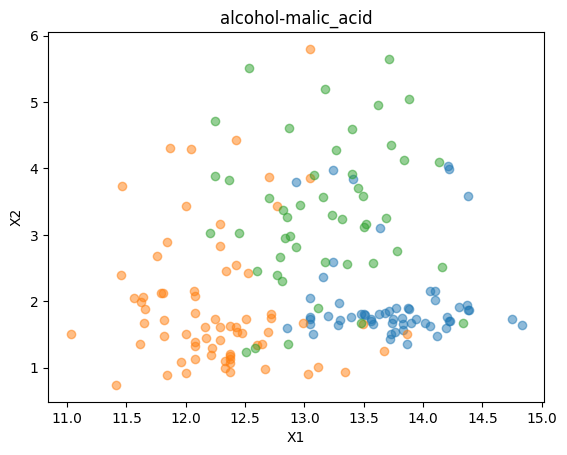

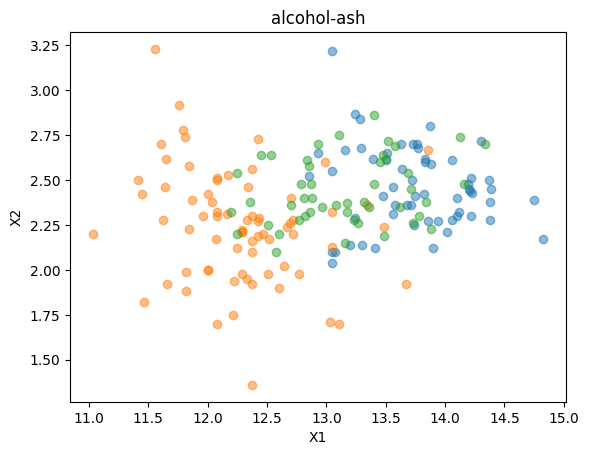

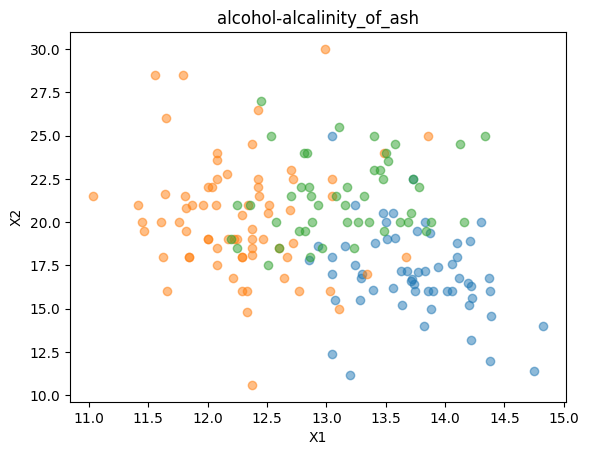

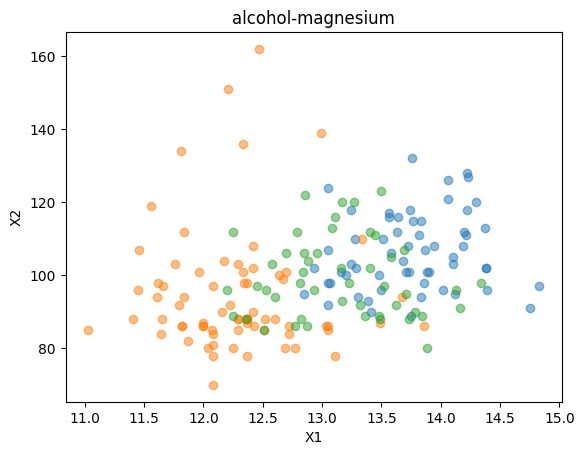

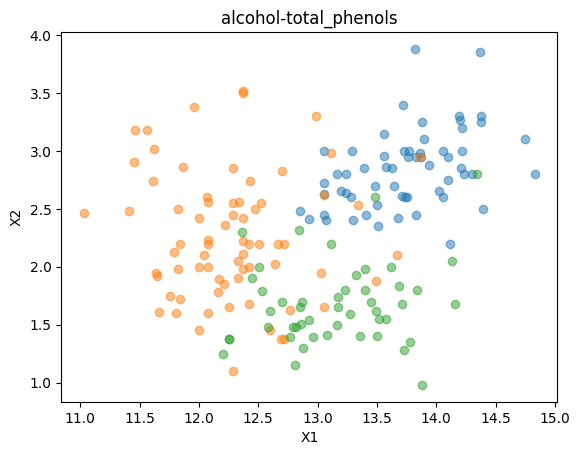

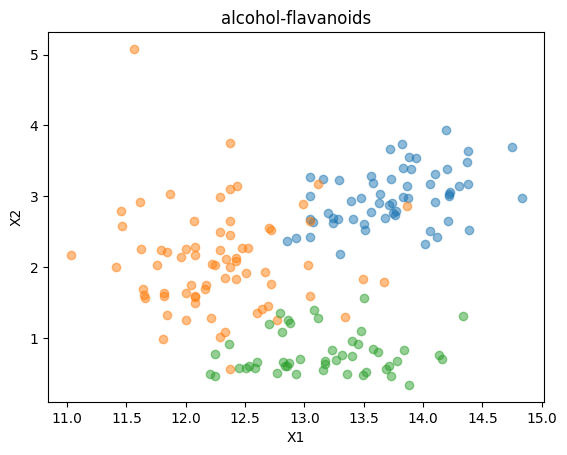

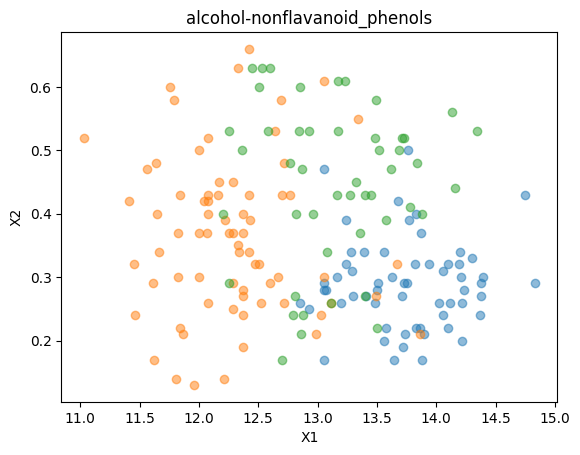

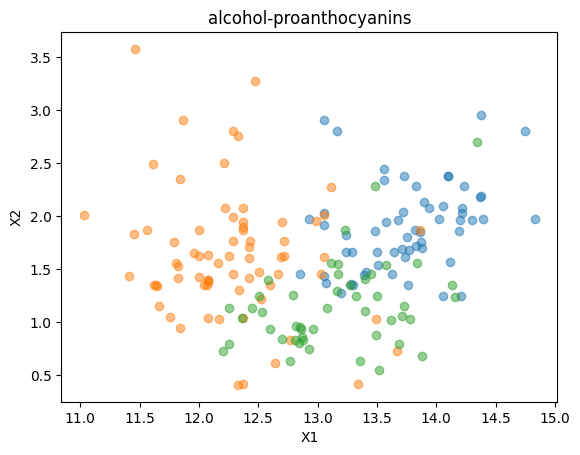

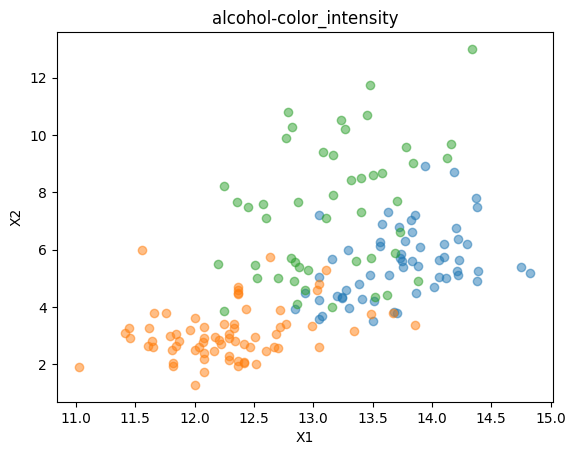

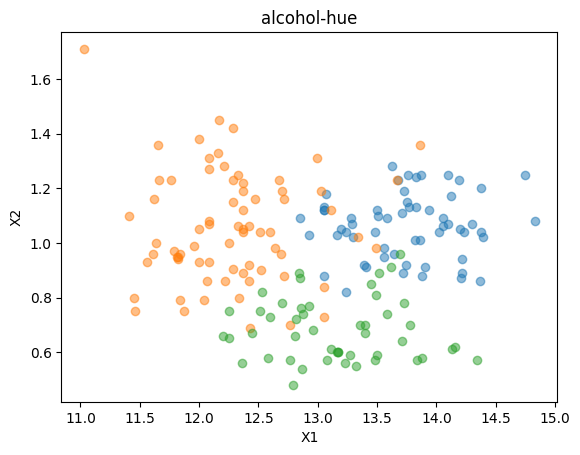

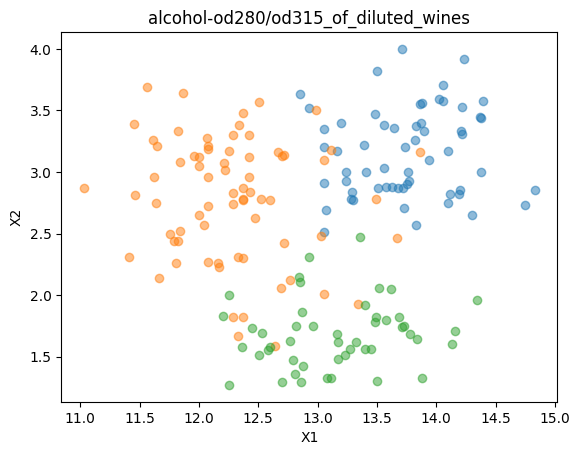

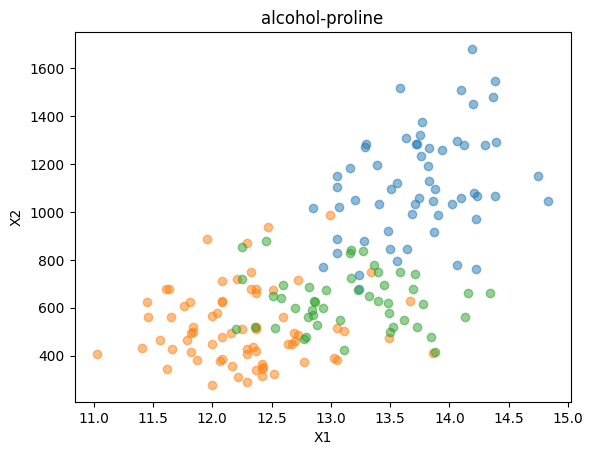

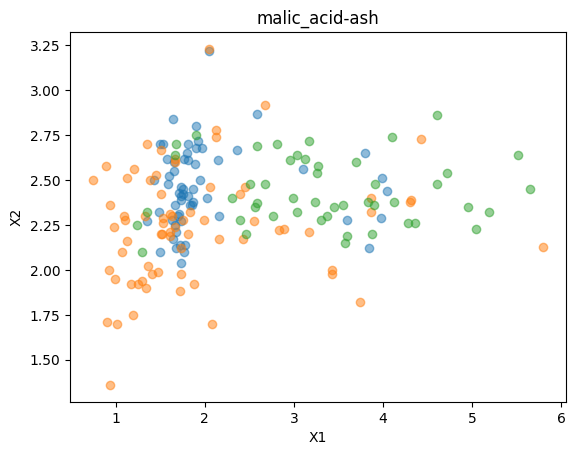

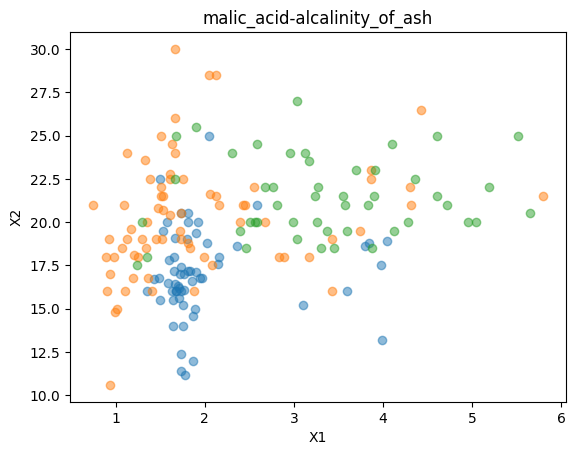

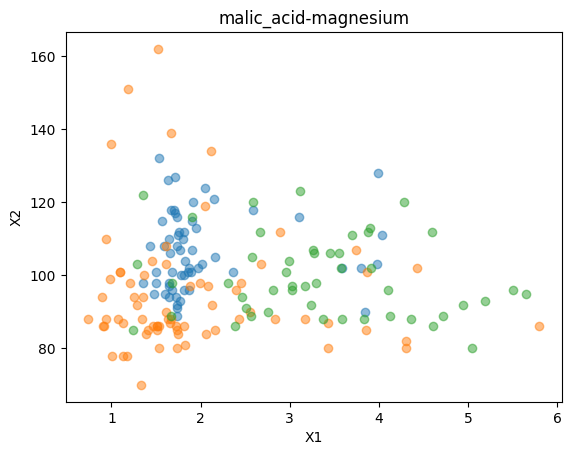

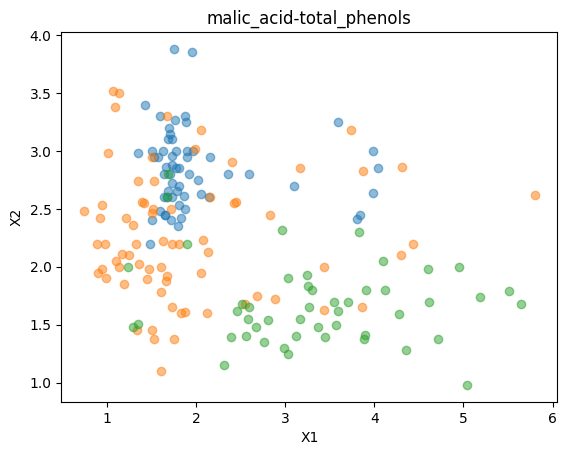

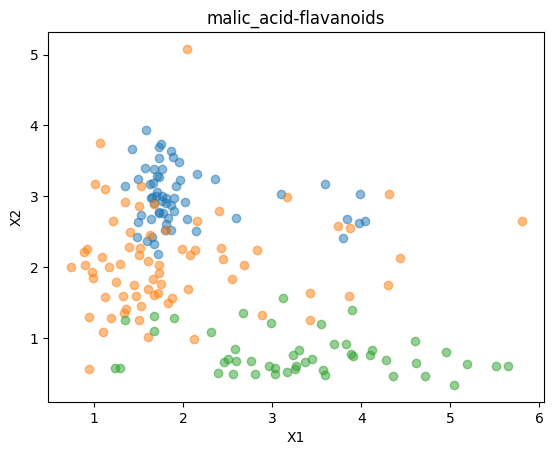

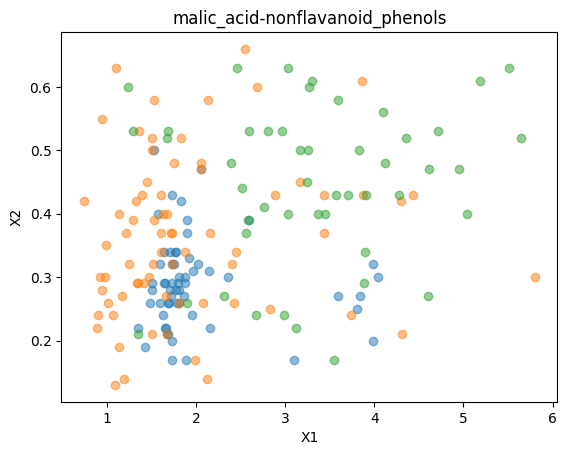

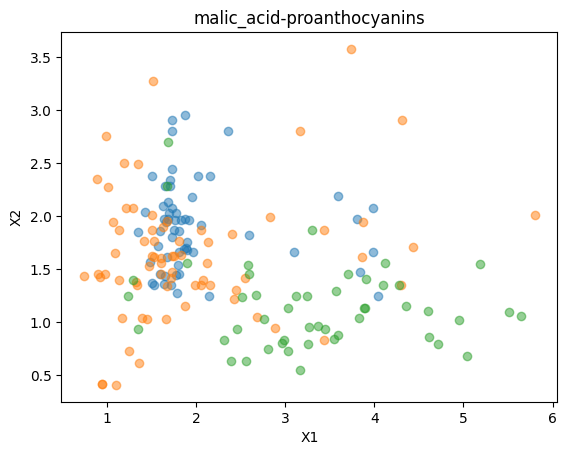

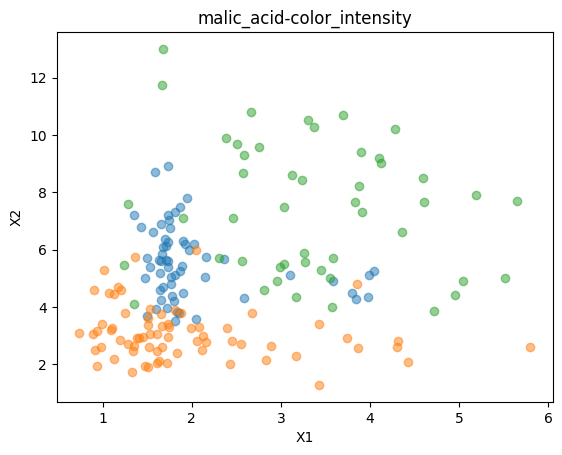

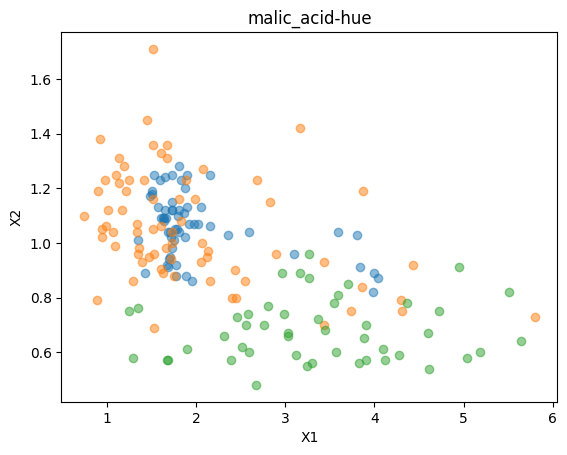

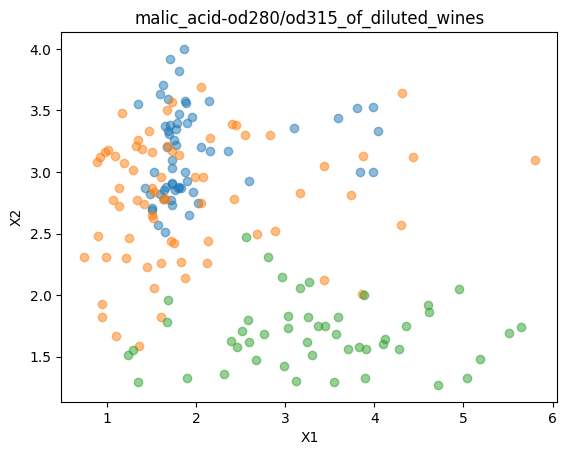

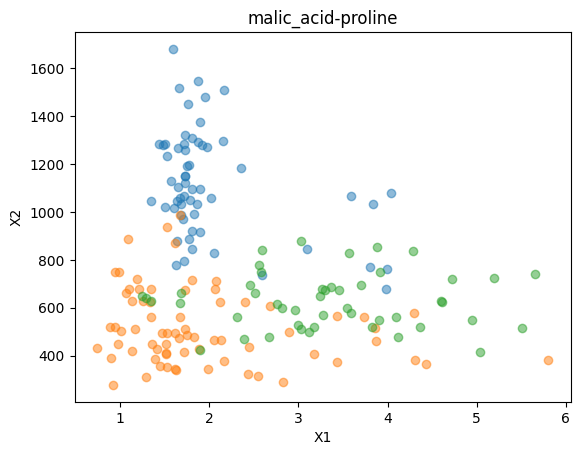

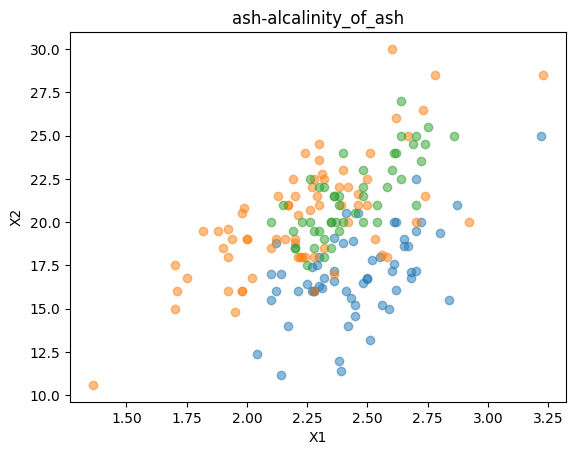

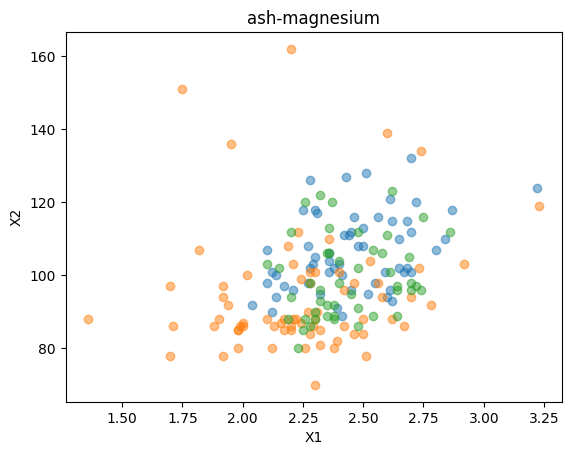

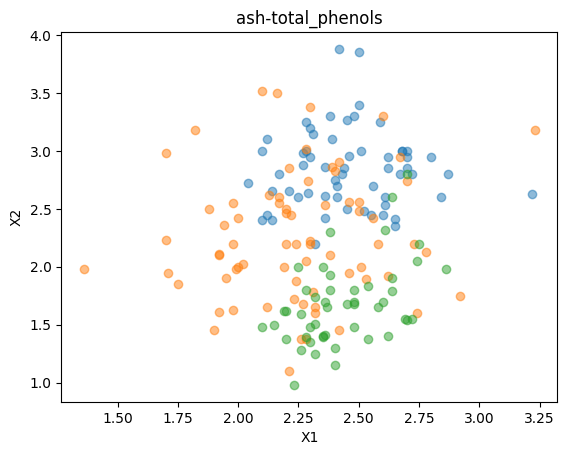

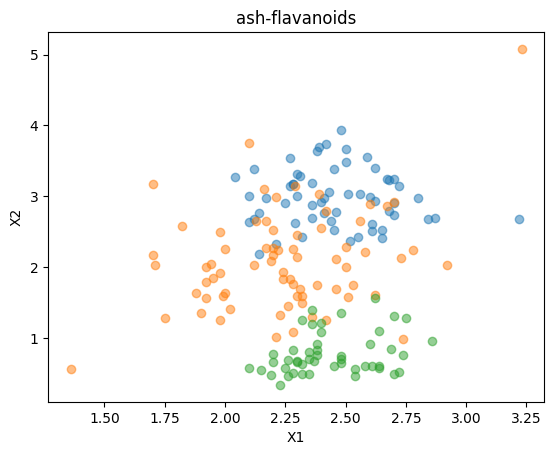

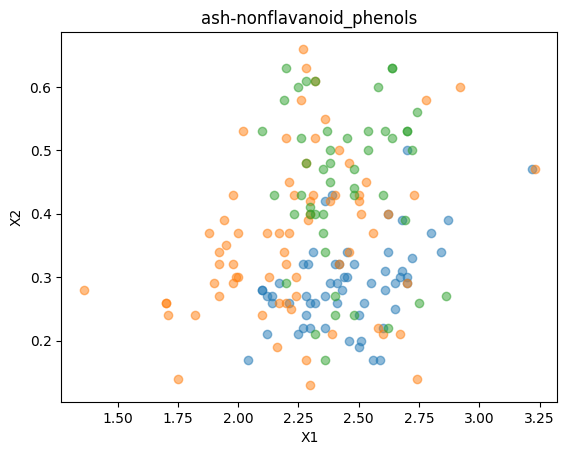

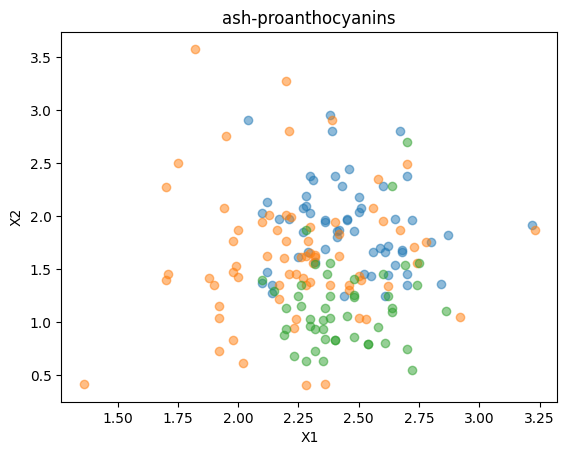

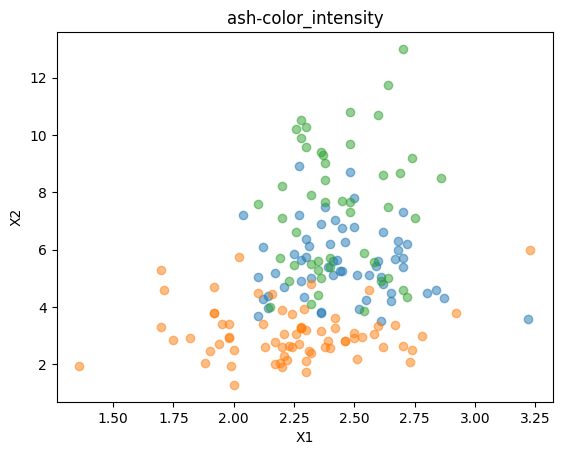

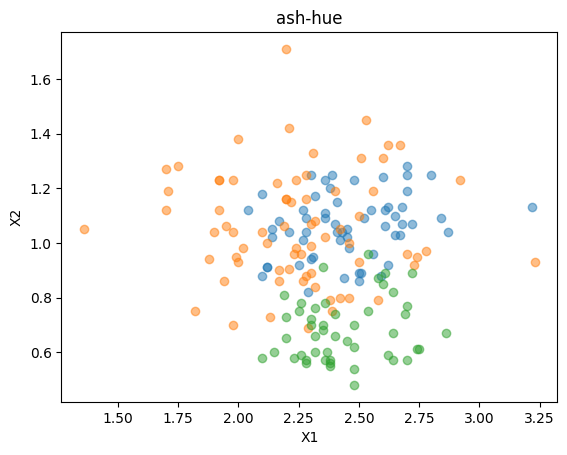

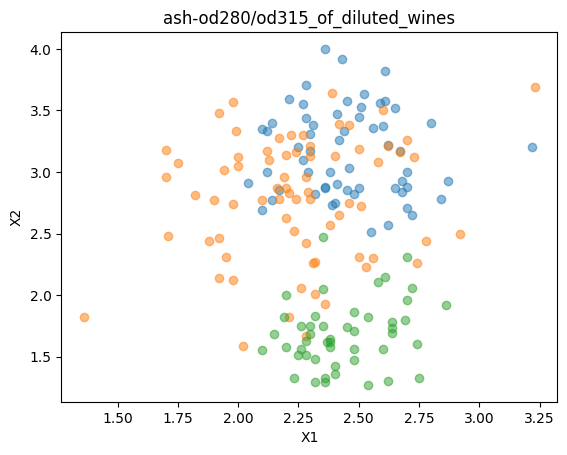

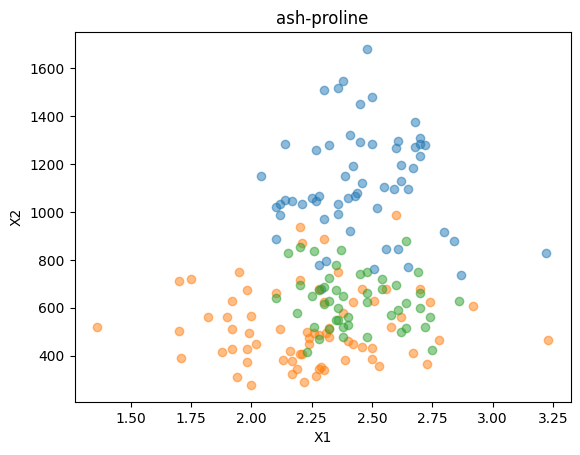

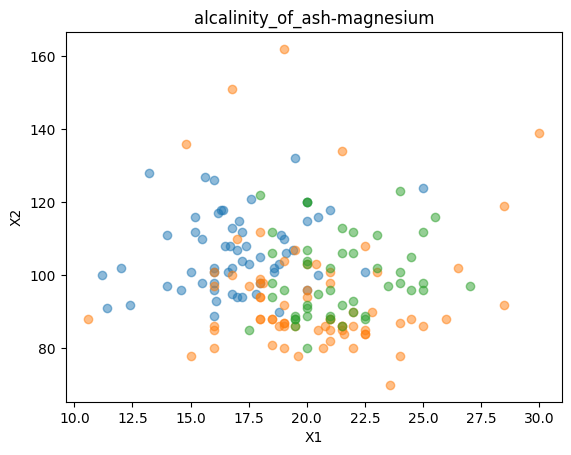

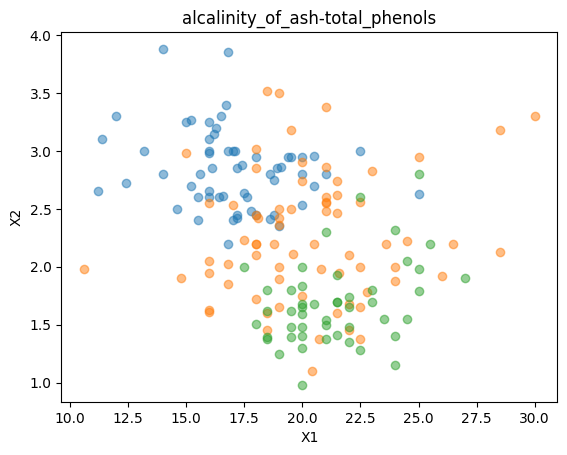

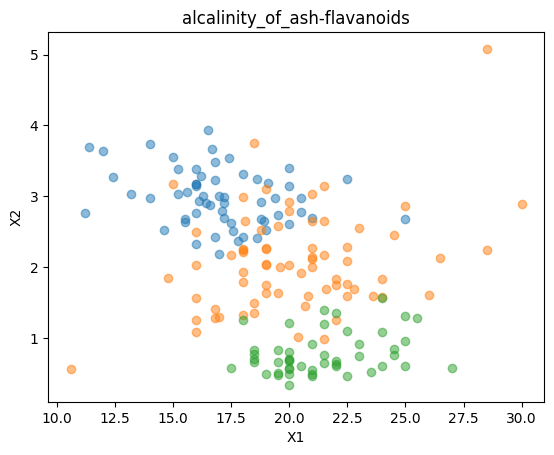

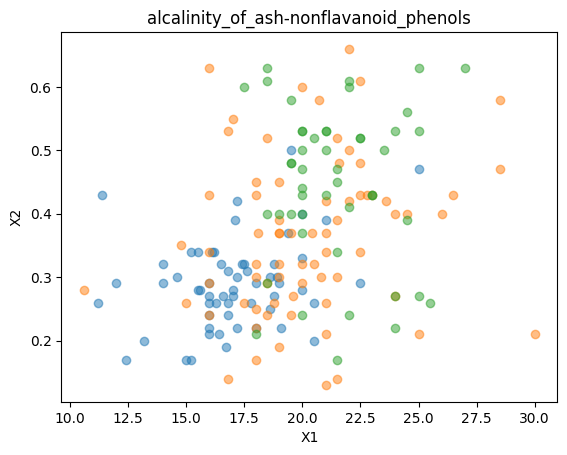

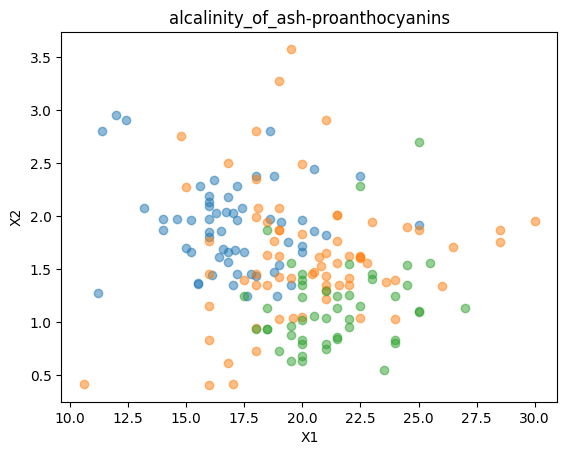

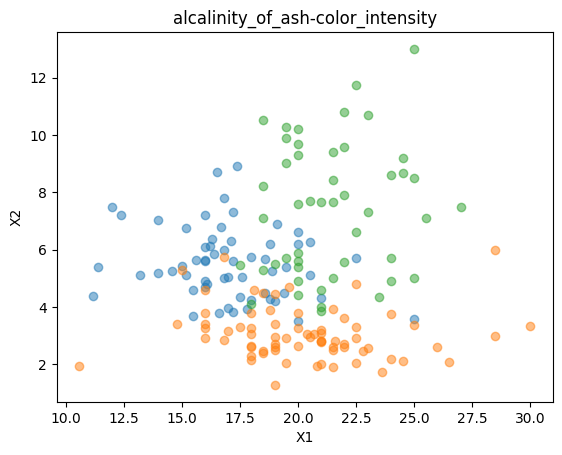

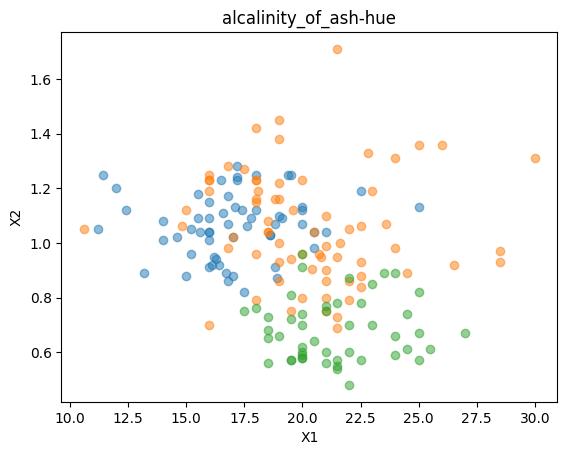

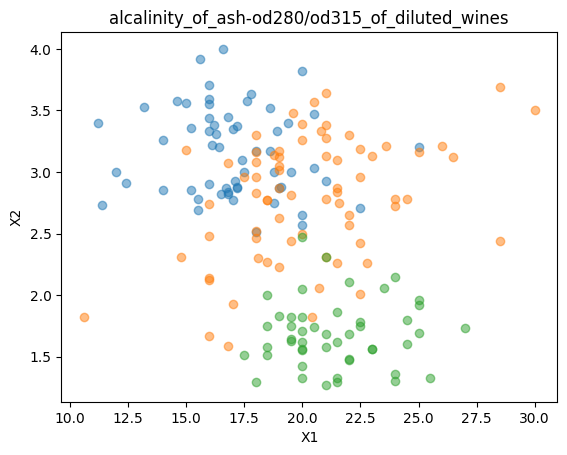

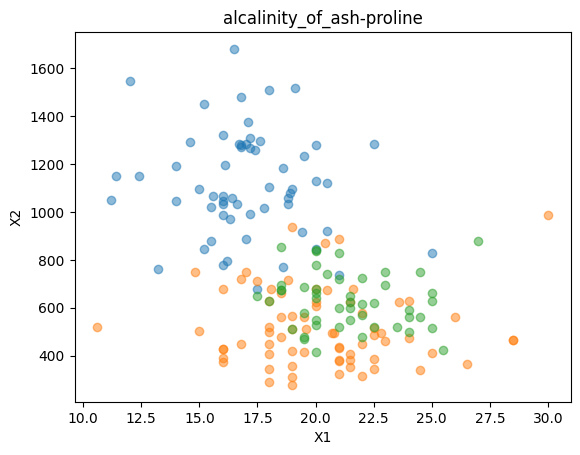

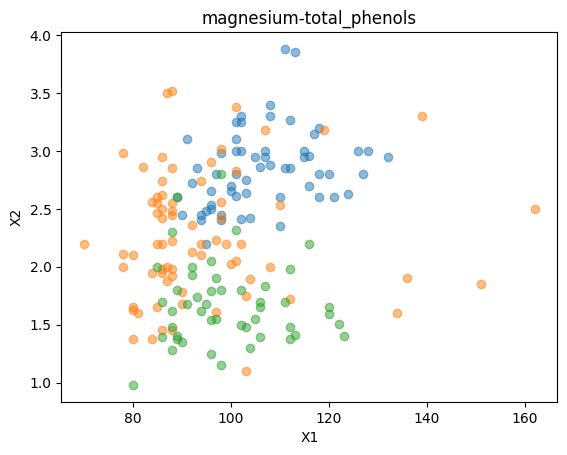

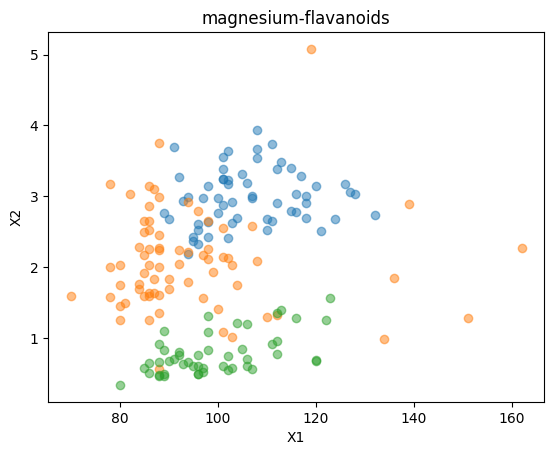

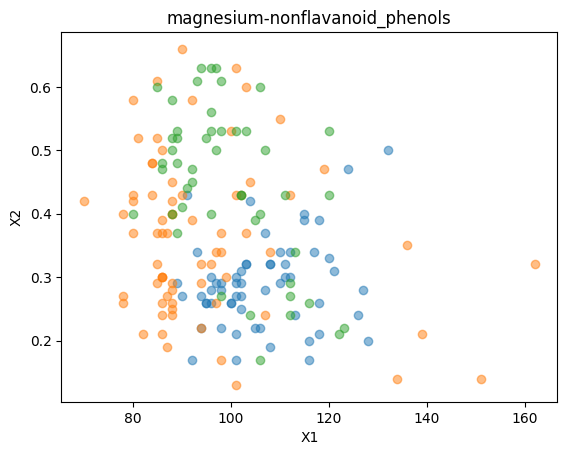

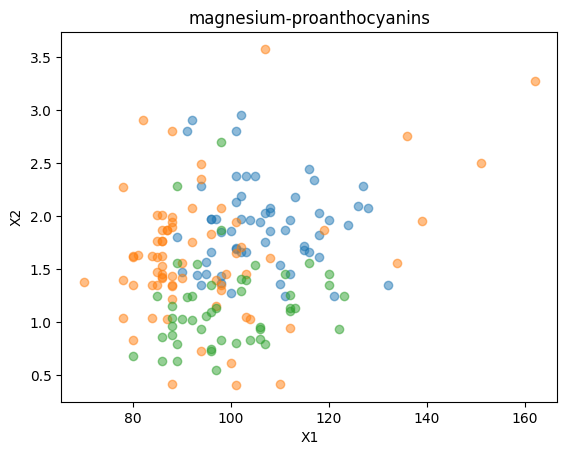

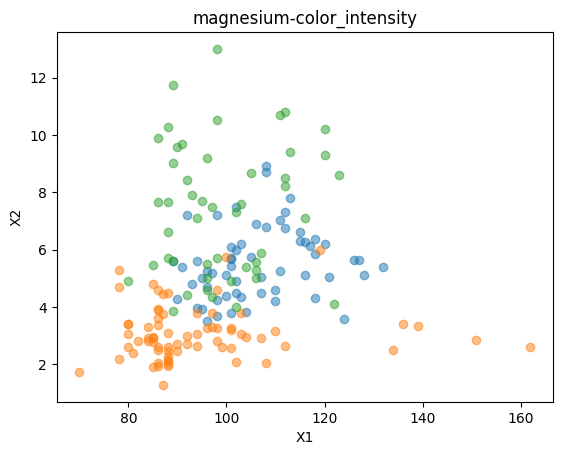

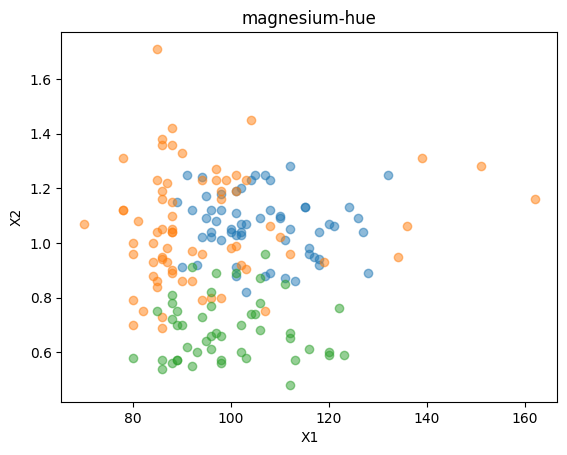

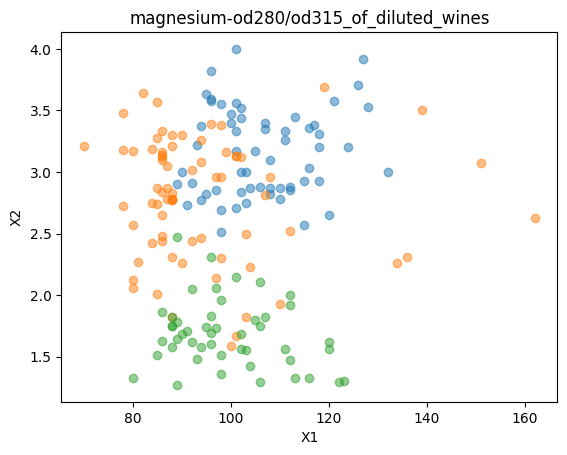

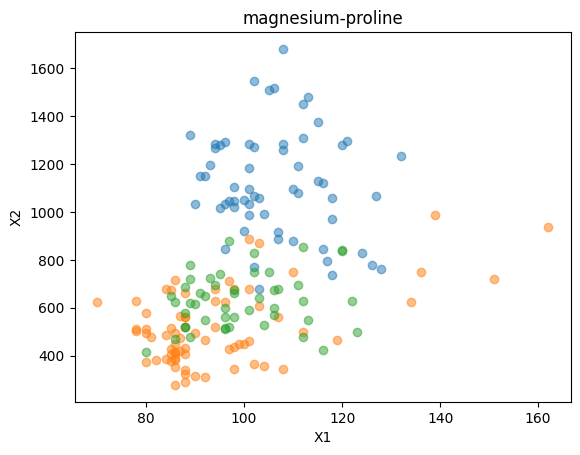

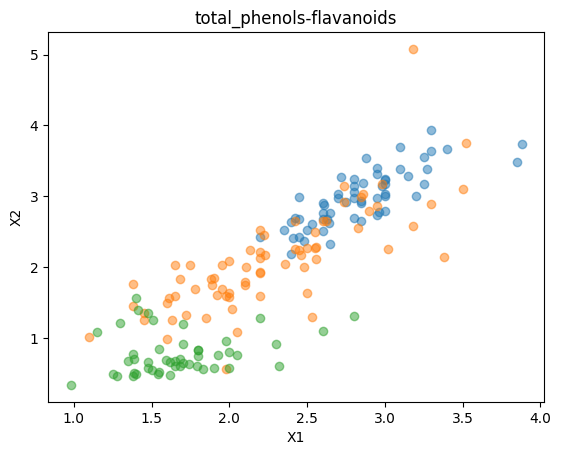

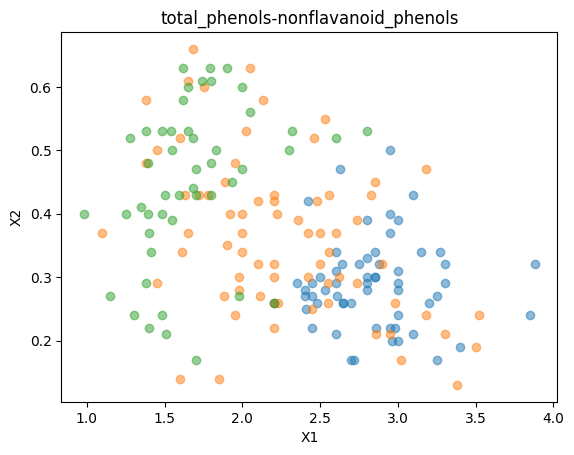

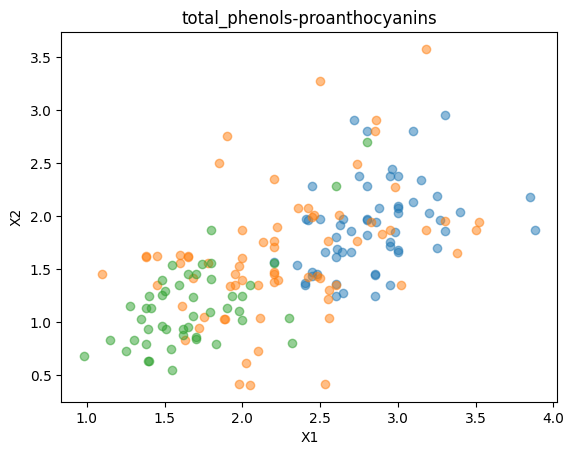

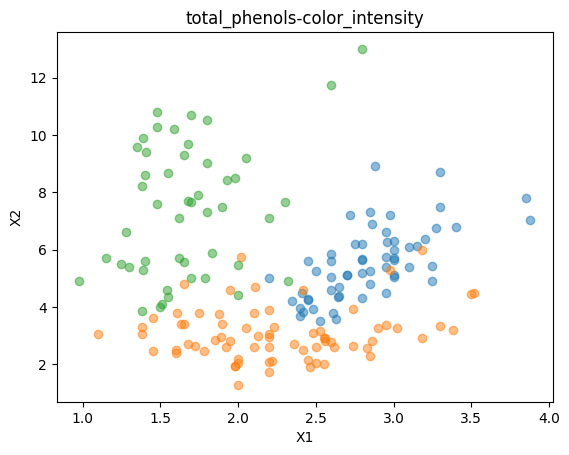

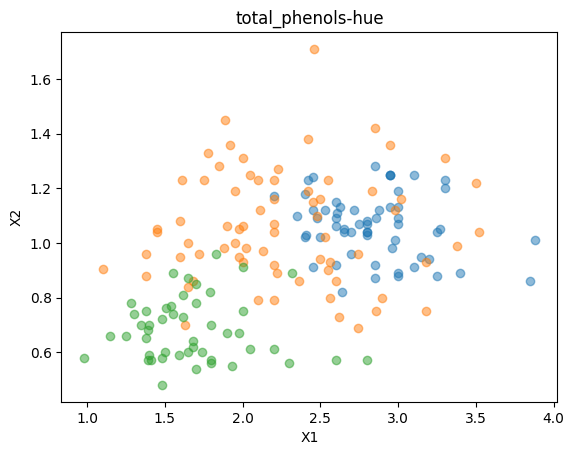

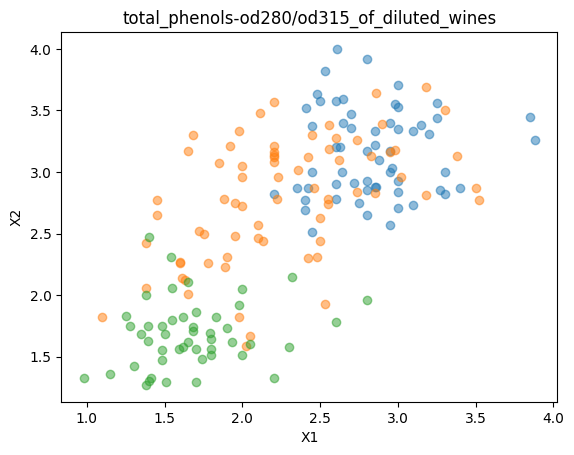

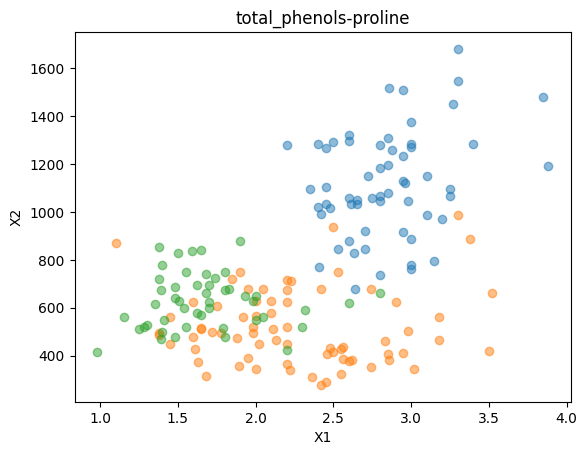

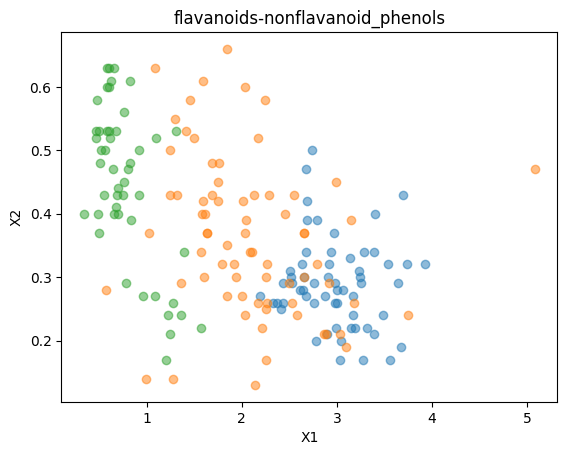

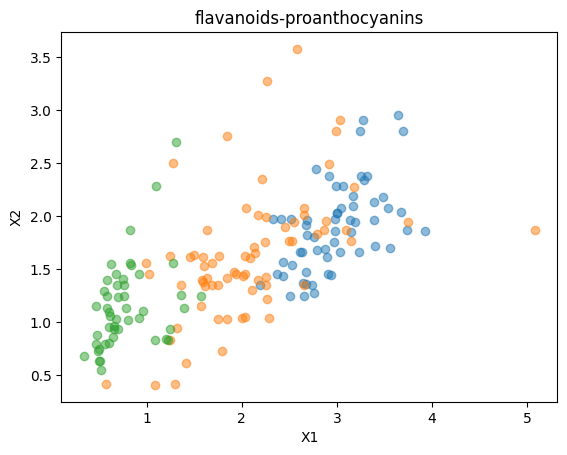

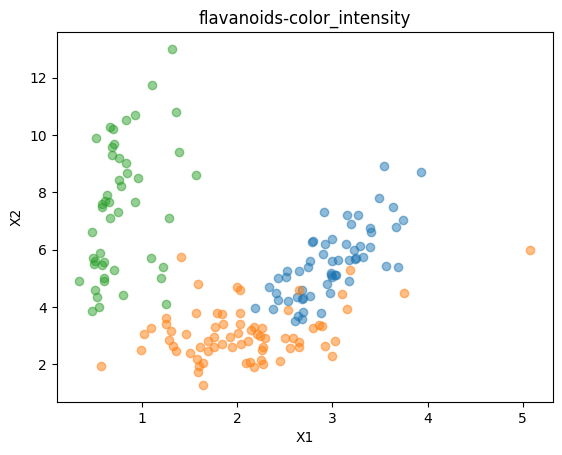

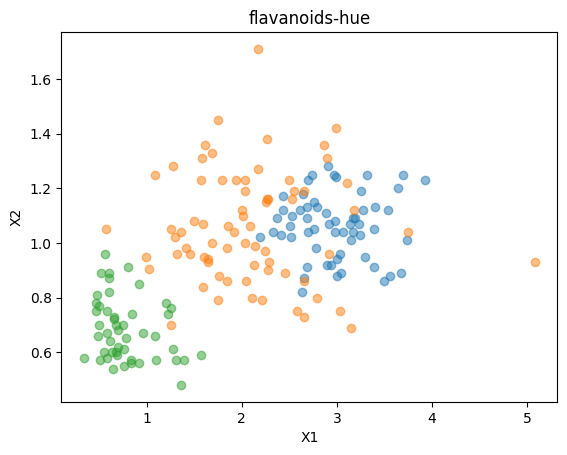

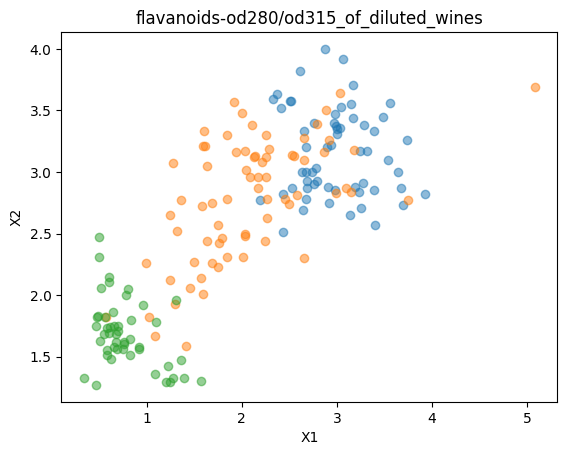

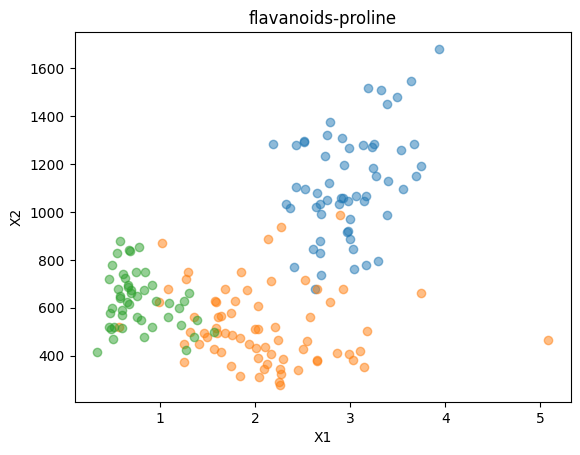

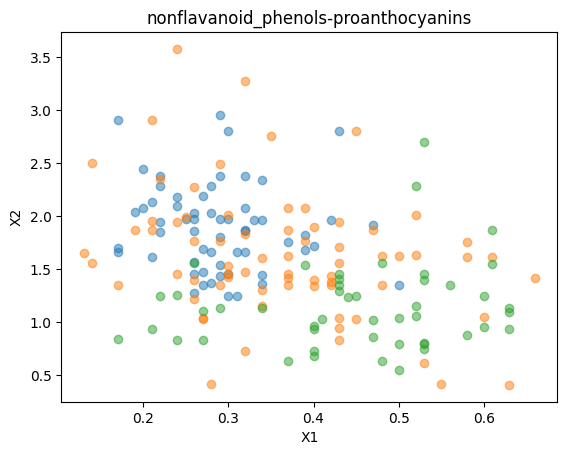

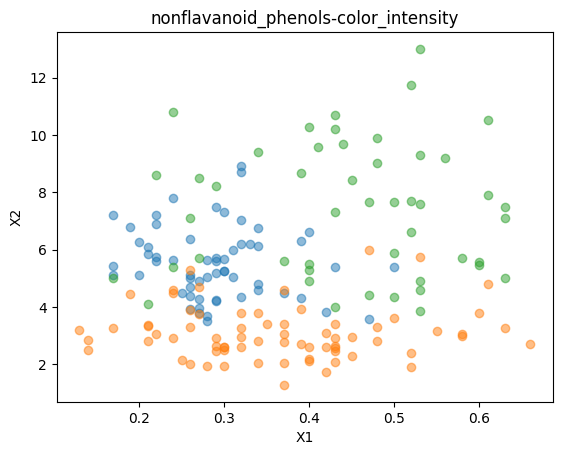

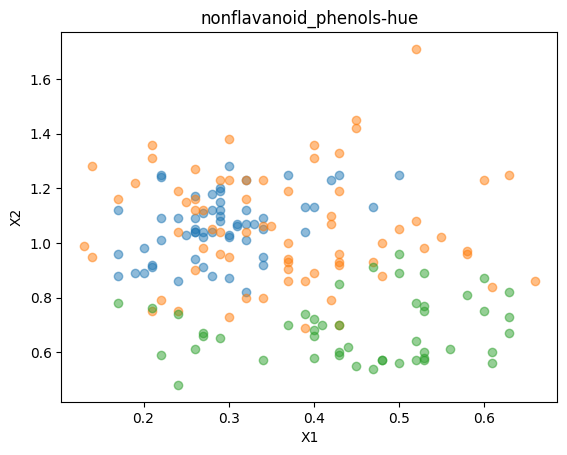

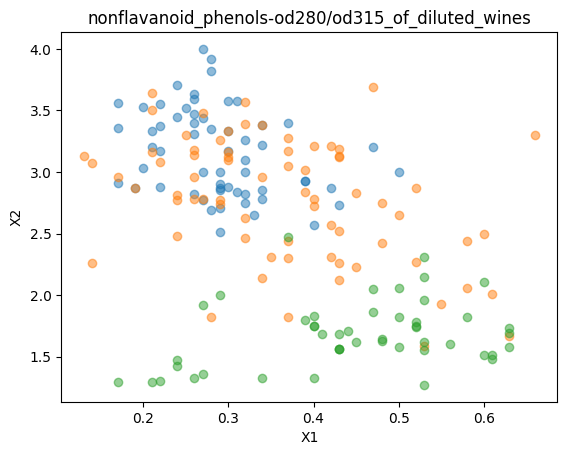

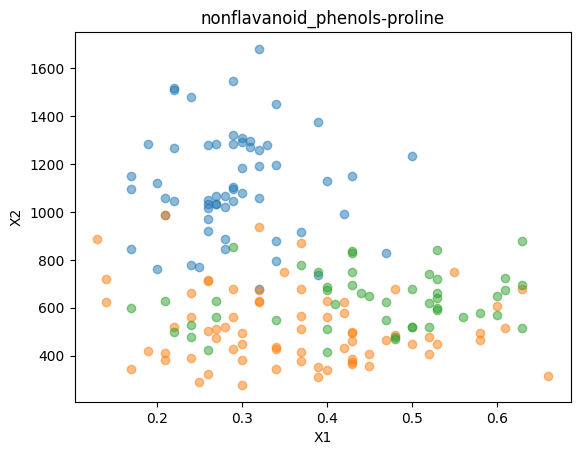

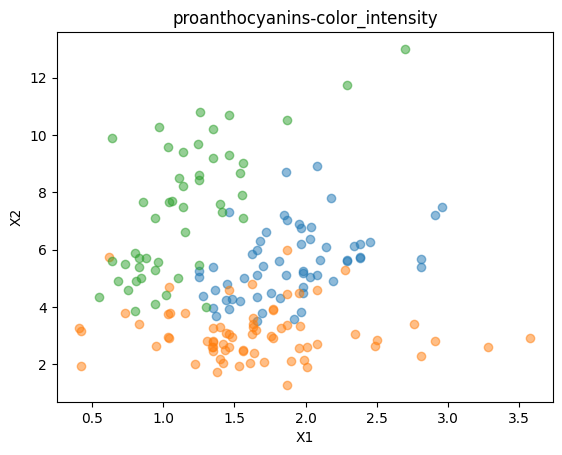

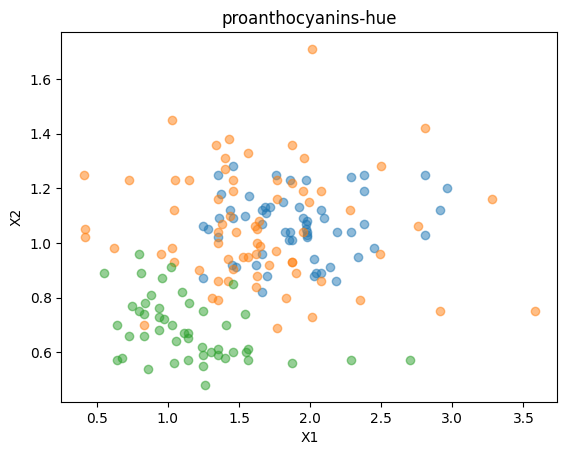

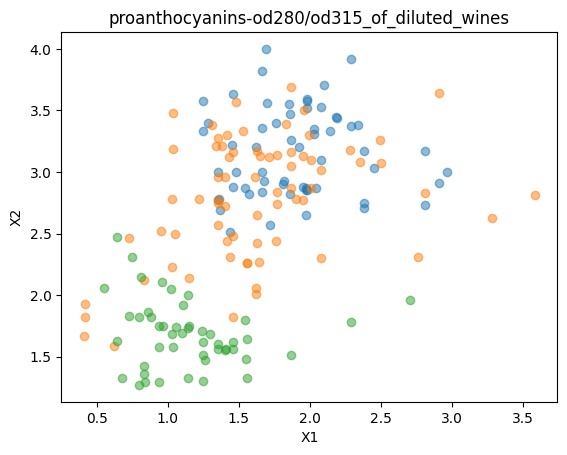

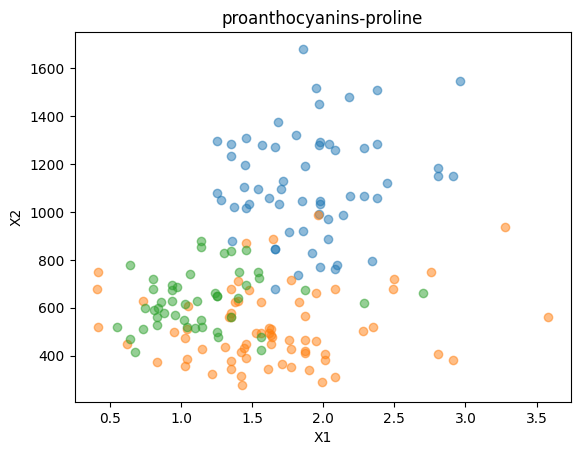

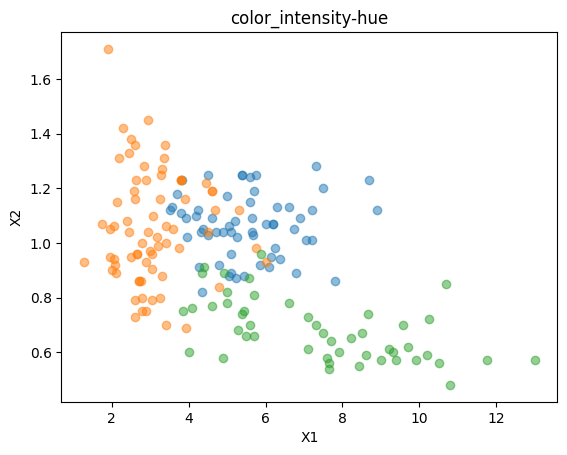

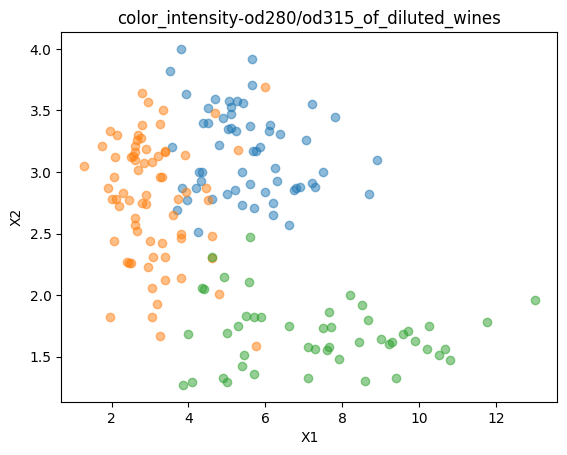

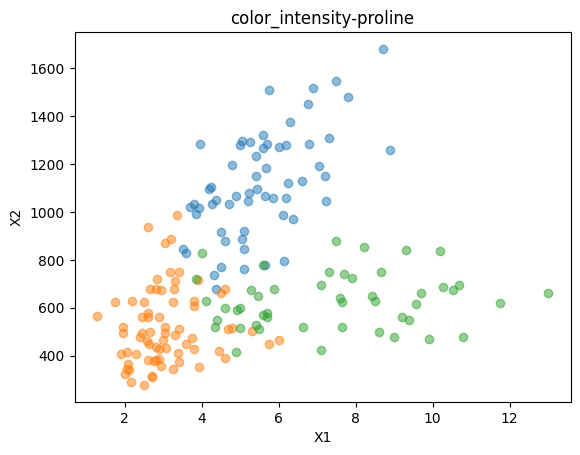

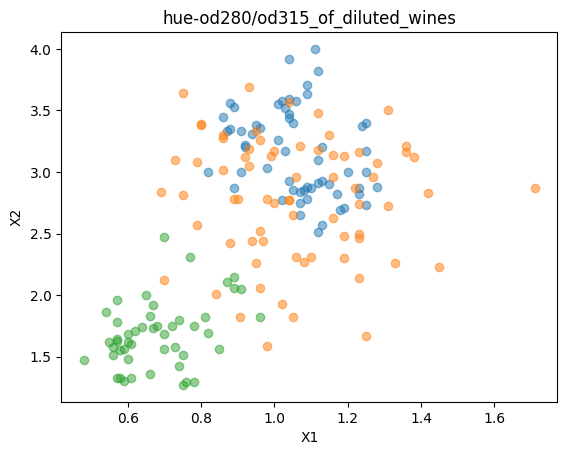

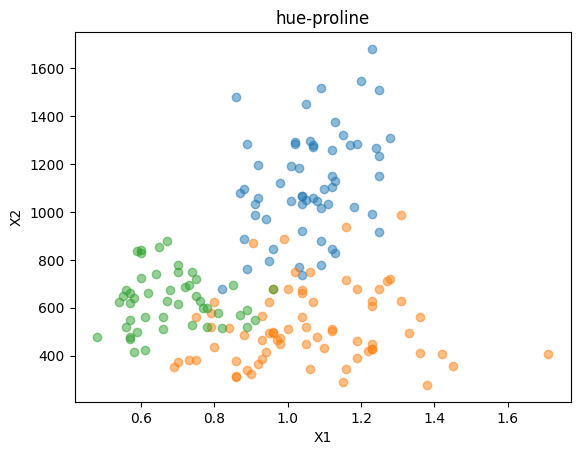

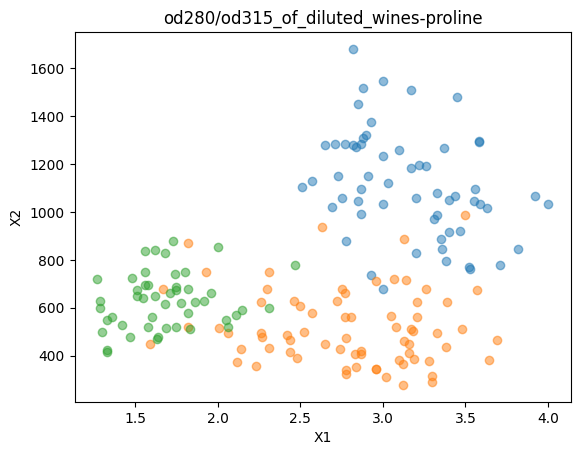

In [4]:
def plotaDatasetBidimensional(X, y, title=''):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(title)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], "o", alpha=0.5)

ytr = dataset.target
tot_cols = len(df.columns)
for i_f1 in range(tot_cols-1):
  for i_f2 in range(i_f1+1, tot_cols, 1):
    f1 = df.columns[i_f1]
    f2 = df.columns[i_f2]
    Xtr = df[[f1, f2]].values
    plotaDatasetBidimensional(Xtr, ytr, title=f"{f1}-{f2}")
    plt.show()

In [5]:
Xtr = df[["flavanoids", "od280/od315_of_diluted_wines"]].values
ytr = dataset.target


In [6]:
min(Xtr[:,1]),max(Xtr[:,1])

(1.27, 4.0)

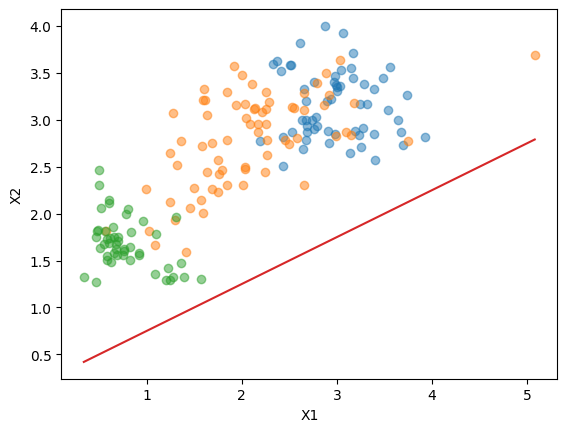

In [7]:
def plotaHiperplanoDatasetBidimensional(X, vetor, intercept=0):
    """
    Plota um definido por um
    vetor e o valor em que este vetor
    intercepta o eixo vertical.
    """
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    xs = np.linspace(x0min, x0max, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - intercept / vetor[1]
    plt.plot(xs,ys)

plotaDatasetBidimensional(Xtr, ytr)
vetor_hyperplano = np.array([2, 4]) * np.array([1, -1])
plotaHiperplanoDatasetBidimensional(Xtr, vetor_hyperplano, 1)

In [8]:
def sign(a):
    return (a >= 0) * 2 - 1

In [9]:
class Custo(ABC):
    @abstractstaticmethod
    def custo(y, ypred):
        pass
    @abstractstaticmethod
    def gradiente(y, ypred, X):
        pass

class WidrowHoff(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - (y * ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - ypred)

class SmoothedSurrogate(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - sign(ypred))

class HingeLoss(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        errosmarginais = (y * ypred) < 1
        ymarginais = np.copy(y)
        ymarginais[~errosmarginais] = 0
        g = X.T @ ymarginais
        return g

class LogLikelihood(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.log(1 + np.exp(- y * ypred)))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - (expit(ypred)*2-1))


In [10]:
class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self, X, y, activation):
    pass

class PseudoInversa(TrainingAlgorithm):
  def __init__(self, regularization=0):
    self.regularization = regularization
  def getW(self, X, y):
    return np.linalg.inv(X.T @ X + np.eye(X.shape[1])*self.regularization) @ X.T @ y


class DescidaGradiente(TrainingAlgorithm):
  def __init__(self, max_iter=100, learning_rate=0.05,
               regularization=0, cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost

  def getW(self, X, y):
    w = np.random.uniform(-1, 1, size=(X.shape[1], y.shape[1]))
    for _ in range(self.max_iter):
      ypred = X @ w
      if self.cost.custo(y, ypred) == 0:
        break
      w *= 1 - self.regularization * self.learning_rate
      w += self.cost.gradiente(y, ypred, X) * self.learning_rate
    return w

In [11]:
def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class Perceptron(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=DescidaGradiente()):
    self.w = None
    self.training_algorithm = training_algorithm

  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels)*2-1

  def fit(self, X, y):
    Xb = include_bias(X)
    yhot = self.encode_labels(y)
    self.w = self.training_algorithm.getW(Xb, yhot)

  def __pre_activation(self, X):
    Xb = include_bias(X)
    return Xb @ self.w

  def predict(self, X):
    a = self.__pre_activation(X)
    if self.w.shape[1] == 1:
      idx = np.array(a > 0, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

0.8089887640449438
[[-4.59332385 -2.00281939  4.79657164]
 [ 2.31078035 -0.5314655  -3.23278419]
 [-0.47568142  1.02526921 -0.52985515]]


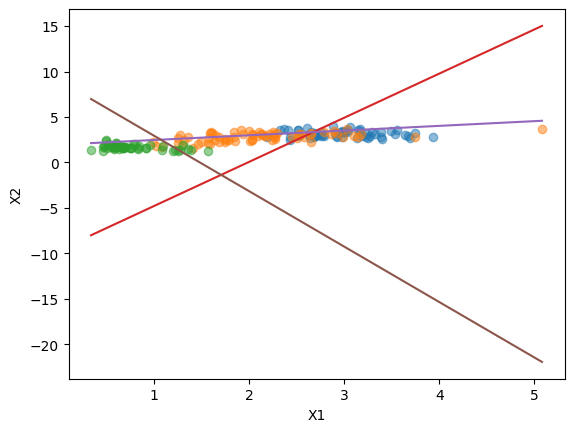

In [12]:
perceptron = Perceptron(
    training_algorithm=DescidaGradiente(
        cost=LogLikelihood(),
        max_iter=1000,
        learning_rate=0.0005,
        )
    )
perceptron.fit(Xtr, ytr)
print(accuracy_score(ytr, perceptron.predict(Xtr)))
print(perceptron.w)
plotaDatasetBidimensional(Xtr, ytr)


if perceptron.w.shape[1] == 1:
  plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:], perceptron.w[0])
else:
  for i in range(perceptron.w.shape[1]):
    plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:,i], perceptron.w[0,i])

0.7471910112359551


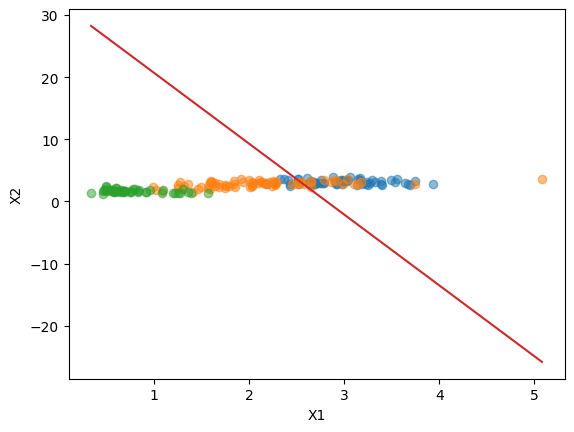

In [13]:
model = RidgeClassifier()
model.fit(Xtr, ytr)
y_pred = model.predict(Xtr)
print(accuracy_score(ytr, y_pred))

plotaDatasetBidimensional(Xtr, ytr)

vetor = model.coef_[0]
intercept = model.intercept_[0]
plotaHiperplanoDatasetBidimensional(Xtr, vetor, intercept)

plt.xlabel('X1')
plt.ylabel('X2')
plt.show()


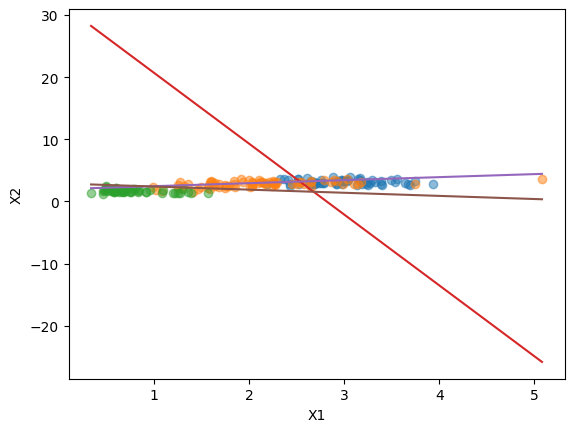

In [14]:
plotaDatasetBidimensional(Xtr, ytr)
for i in range(model.coef_.shape[0]):
    plotaHiperplanoDatasetBidimensional(Xtr, model.coef_[i], model.intercept_[i])
    # Defina rótulos dos eixos
    plt.xlabel('X1')
    plt.ylabel('X2')
plt.show()

0.8426966292134831


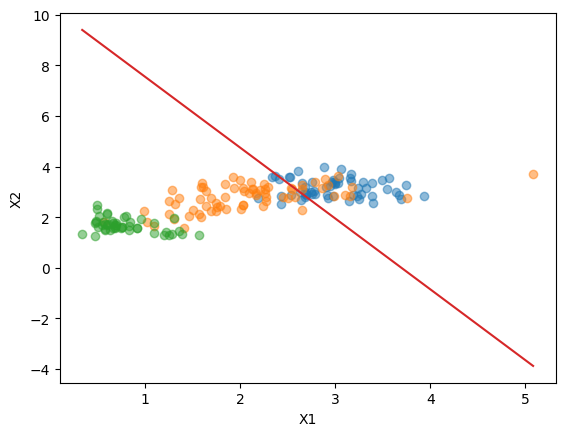

In [15]:
model = SVC(kernel="linear")
model.fit(Xtr, ytr)
y_pred = model.predict(Xtr)
print(accuracy_score(ytr, y_pred))

plotaDatasetBidimensional(Xtr, ytr)

vetor = model.coef_[0]
intercept = model.intercept_[0]
plotaHiperplanoDatasetBidimensional(Xtr, vetor, intercept)

plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

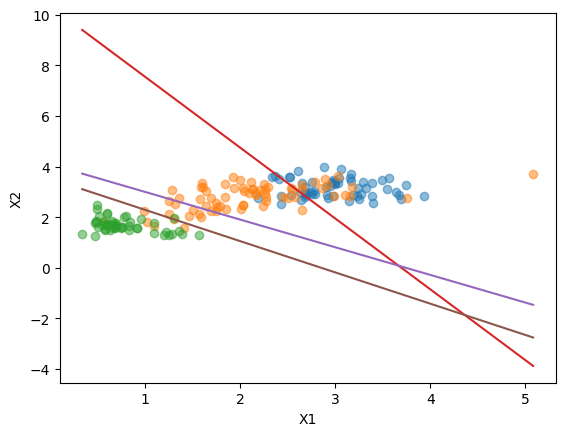

In [16]:
plotaDatasetBidimensional(Xtr, ytr)
for i in range(model.coef_.shape[0]):
    plotaHiperplanoDatasetBidimensional(Xtr, model.coef_[i], model.intercept_[i])
    # Defina rótulos dos eixos
    plt.xlabel('X1')
    plt.ylabel('X2')
plt.show()